In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Now import other libraries or define your model


In [2]:
import ctypes
try:
    ctypes.WinDLL('zlibwapi.dll')  # Test loading the DLL
    print("Success: zlibwapi.dll is accessible!")
except Exception as e:
    print(f"Error: {e}")

Success: zlibwapi.dll is accessible!


In [3]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from keras import backend as K

# Clear previous sessions
K.clear_session()

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (128, 128)
DATA_DIR = "Dataset/preprocessed_images"
META_CSV = "Dataset/meta_train.csv"
EPOCHS = 30
BATCH_SIZE = 32

In [7]:
meta_df = pd.read_csv(META_CSV)
label_map = {label: idx for idx, label in enumerate(meta_df["label"].unique())}
meta_df["label_encoded"] = meta_df["label"].map(label_map)
meta_df["variety_encoded"] = pd.factorize(meta_df["variety"])[0]
num_classes = len(meta_df["variety_encoded"].unique())
CLASS_NAMES = meta_df["variety"].unique()

In [8]:
X, y = [], []

for _, row in meta_df.iterrows():
    img_id = row["image_id"].replace(".jpg", "")
    try:
        red = img_to_array(load_img(os.path.join(DATA_DIR, row["label"], img_id + "_red.jpg"), target_size=IMG_SIZE)) / 255.0
        green = img_to_array(load_img(os.path.join(DATA_DIR, row["label"], img_id + "_green.jpg"), target_size=IMG_SIZE)) / 255.0
        blue = img_to_array(load_img(os.path.join(DATA_DIR, row["label"], img_id + "_blue.jpg"), target_size=IMG_SIZE)) / 255.0
        spectral = img_to_array(load_img(os.path.join(DATA_DIR, row["label"], img_id + "_nipy_spectral.jpg"),
                                         target_size=IMG_SIZE, color_mode="grayscale")) / 255.0
        spectral = np.repeat(spectral, 3, axis=-1)
        img_array = np.concatenate([red, green, blue, spectral], axis=-1)
        X.append(img_array)
        y.append(row["variety_encoded"])
    except FileNotFoundError:
        continue

X = np.array(X)
y = to_categorical(y, num_classes=num_classes)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)


In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 12)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [11]:
# 1. Create the datagen generator
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
)

# 2. Fit the model using the generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

c:\Users\Administrator\anaconda3\envs\tf-gpu\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8325, 128, 128, 12) (12 channels).
  warnings.warn(


Epoch 1/30
261/261 [==============================] - 132s 500ms/step - loss: 1.1960 - accuracy: 0.6804 - val_loss: 1.2123 - val_accuracy: 0.6739
Epoch 2/30
261/261 [==============================] - 122s 468ms/step - loss: 0.9514 - accuracy: 0.7117 - val_loss: 0.8678 - val_accuracy: 0.7248
Epoch 3/30
261/261 [==============================] - 128s 492ms/step - loss: 0.7910 - accuracy: 0.7407 - val_loss: 0.6281 - val_accuracy: 0.7959
Epoch 4/30
261/261 [==============================] - 131s 500ms/step - loss: 0.6593 - accuracy: 0.7791 - val_loss: 0.6305 - val_accuracy: 0.8103
Epoch 5/30
261/261 [==============================] - 112s 431ms/step - loss: 0.5686 - accuracy: 0.8100 - val_loss: 0.4538 - val_accuracy: 0.8578
Epoch 6/30
261/261 [==============================] - 133s 510ms/step - loss: 0.4918 - accuracy: 0.8322 - val_loss: 0.4171 - val_accuracy: 0.8578
Epoch 7/30
261/261 [==============================] - 131s 503ms/step - loss: 0.4279 - accuracy: 0.8550 - val_loss: 0.3703 -

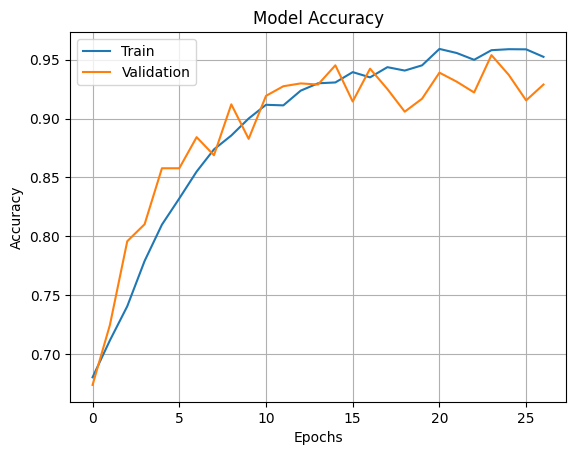

In [19]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("epoch-accuracy.svg", bbox_inches="tight")
plt.show()

In [14]:
IMAGE_DIR = "Dataset/preprocessed_test_images"

def predict_variety(image_id):
    try:
        red = img_to_array(load_img(f"{IMAGE_DIR}/{image_id}_red.jpg", target_size=IMG_SIZE)) / 255.0
        green = img_to_array(load_img(f"{IMAGE_DIR}/{image_id}_green.jpg", target_size=IMG_SIZE)) / 255.0
        blue = img_to_array(load_img(f"{IMAGE_DIR}/{image_id}_blue.jpg", target_size=IMG_SIZE)) / 255.0
        spectral = img_to_array(
            load_img(f"{IMAGE_DIR}/{image_id}_nipy_spectral.jpg", target_size=IMG_SIZE, color_mode="grayscale")
        ) / 255.0
        spectral = np.repeat(spectral, 3, axis=-1)  # Convert grayscale to 3 channels

        # Stack into (128, 128, 12)
        img_array = np.concatenate([red, green, blue, spectral], axis=-1)
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_variety = CLASS_NAMES[predicted_index]
        return predicted_variety
    except Exception as e:
        print(f"Skipping {image_id}: {e}")
        return None

# Collect predictions
all_files = os.listdir(IMAGE_DIR)
image_ids = sorted(set(f.split("_")[0] for f in all_files if f.endswith(".jpg")))

results = []
for image_id in image_ids:
    variety = predict_variety(image_id)
    if variety:
        results.append({"image_id": f"{image_id}.jpg", "variety": variety})

df = pd.DataFrame(results)
df.to_csv("task2_predictions.csv", index=False)
print("Saved predictions to task2_predictions.csv")

Saved predictions to task2_predictions.csv


In [15]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on test set:", acc)

66/66 [==============================] - 1s 10ms/step
Accuracy on test set: 0.9423631123919308


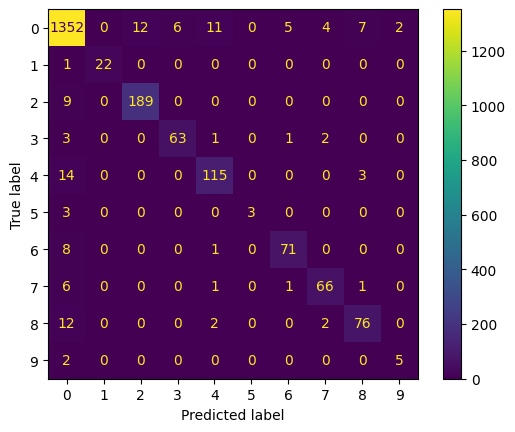

In [16]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(cm).plot()

In [20]:
print(classification_report(y_true_labels, y_pred_labels, target_names=CLASS_NAMES))

                precision    recall  f1-score   support

         ADT45       0.96      0.97      0.96      1399
          IR20       1.00      0.96      0.98        23
KarnatakaPonni       0.94      0.95      0.95       198
      Onthanel       0.91      0.90      0.91        70
         Ponni       0.88      0.87      0.87       132
         Surya       1.00      0.50      0.67         6
         Zonal       0.91      0.89      0.90        80
    AndraPonni       0.89      0.88      0.89        75
  AtchayaPonni       0.87      0.83      0.85        92
            RR       0.71      0.71      0.71         7

      accuracy                           0.94      2082
     macro avg       0.91      0.85      0.87      2082
  weighted avg       0.94      0.94      0.94      2082



In [21]:
model.save("task2_4colors.keras")